### Import package

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import math
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Random Seed

In [2]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False 
    torch.backends.cudnn.deterministic = True 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seeds(7777)

### Kalman Filter

In [3]:
def kalman_filter(z, Q=1e-4, R=0.01):
    """
    对一维信号应用卡尔曼滤波
    z: 观测值序列
    Q: 过程噪声协方差
    R: 测量噪声协方差
    """
    n = len(z)
    # 初始化
    x_hat = np.zeros(n)  # 状态估计
    P = np.zeros(n)  # 估计误差协方差
    K = np.zeros(n)  # 卡尔曼增益
    # 初始值
    x_hat[0] = z[0]
    P[0] = 1
    # 卡尔曼滤波
    for k in range(1, n):
        # 预测
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q
        # 更新
        K[k] = P_minus / (P_minus + R)
        x_hat[k] = x_hat_minus + K[k] * (z[k] - x_hat_minus)
        P[k] = (1 - K[k]) * P_minus
    return x_hat

### Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len].to(x.device)

class TimeStepAttention(nn.Module):
    def __init__(self, max_len):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(max_len))  # [max_len]

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        seq_len = x.size(1)
        weight = self.alpha[:seq_len].unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1]
        return x * weight  # broadcasting

class TransformerAutoencoderLSTM(nn.Module):
    def __init__(self, input_dim, model_dim=128, num_heads=1, num_layers=1, ff_dim=256, lstm_hidden_dim=64, max_seq_len=10000):
        super().__init__()
        self.model_dim = model_dim
        self.max_seq_len = max_seq_len

        self.input_fc = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, max_len=max_seq_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.time_attention = TimeStepAttention(max_len=max_seq_len)

        self.lstm = nn.LSTM(input_size=model_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.lstm_to_model_dim = nn.Linear(lstm_hidden_dim, model_dim) if lstm_hidden_dim != model_dim else nn.Identity()

        decoder_layer = nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_fc = nn.Linear(model_dim, input_dim)

    def generate_causal_mask(self, size, device):
        # [seq_len, seq_len] 下三角，True 表示要屏蔽（即 mask）
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask.to(device)

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        batch_size, seq_len, _ = x.shape
        device = x.device

        x = self.input_fc(x)
        x = self.pos_encoder(x)                        # -> [B, T, D]

        causal_mask = self.generate_causal_mask(seq_len, device=device)  # [T, T]

        memory = self.encoder(x,mask=causal_mask)     # 加因果掩码：仅可看见当前及之前时间步, mask=causal_mask
        memory = self.time_attention(memory)

        lstm_out, _ = self.lstm(memory)
        bottleneck = torch.tanh(self.lstm_to_model_dim(lstm_out))

        out = self.decoder(tgt=bottleneck, memory=memory, tgt_mask=causal_mask)
        out = self.output_fc(out)
        return out


In [5]:
# 1. 数据加载与预处理
def load_and_preprocess_data(filepath,sequence_length = 10):
    """加载指定范围的数据并标准化"""
    # 只读取10000-20000行的数据
    df = pd.read_csv(filepath, skiprows=range(1, 10000), nrows=10000)
    features = ['throttle', 'gps_alt','nav_alt','accel_x', 'vias','gps_vn','gps_ve','anomaly']
    for col in features:
        if col != 'anomaly':
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    X = []
    for i in range(len(df) - sequence_length + 1):
        X.append(df[features].values[i:i + sequence_length])
    return np.array(X)

In [6]:
SEQ_LENGTH = 30
Paths = [r"代码数据/merged_with_bias_anomaly.csv",
         r"代码数据/merged_with_drift_anomaly.csv",
         r"代码数据/merged_with_stuck_anomaly.csv"]

In [7]:
# 加载指定范围的数据
X = load_and_preprocess_data(Paths[0], sequence_length = SEQ_LENGTH)
# 异常数据在17002-18002行，对应读取数据的索引是(17002-10000)到(18002-10000)，即7002-8002
labels = np.zeros(len(X))
anomaly_start = 8002
anomaly_end = 9002
labels[8002:9002] = 1
# 分离正常样本和异常样本
normal_indices = np.where(labels == 0)[0]
anomaly_indices = np.where(labels == 1)[0]
# 将正常样本分为训练集和测试集的一部分
X_normal = X[normal_indices]
X_train, X_normal_test = train_test_split(X_normal, test_size=0.3, random_state=42)
# 测试集包含所有异常样本和一部分正常样本
X_test = np.vstack([X[anomaly_indices], X_normal_test])
y_test = np.hstack([np.ones(len(anomaly_indices)), np.zeros(len(X_normal_test))])

In [8]:
def train_model(model, dataloader, num_epochs=20, lr=1e-3):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    plot_loss = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(device)
            output = model(x)
            loss = criterion(output, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        plot_loss.append(total_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")
    return plot_loss

In [9]:
# 构建 DataLoader
X_train = torch.tensor(X_train,dtype=torch.float32)
dataset = TensorDataset(X_train)
loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [10]:
model = TransformerAutoencoderLSTM(input_dim=8)
loss_lst = train_model(model, loader, num_epochs=50)

D:\anaconda\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/50, Loss: 6.8438
Epoch 2/50, Loss: 1.1391
Epoch 3/50, Loss: 0.7270
Epoch 4/50, Loss: 0.5272
Epoch 5/50, Loss: 0.4147
Epoch 6/50, Loss: 0.3397
Epoch 7/50, Loss: 0.2823
Epoch 8/50, Loss: 0.2402
Epoch 9/50, Loss: 0.2067
Epoch 10/50, Loss: 0.1796
Epoch 11/50, Loss: 0.1567
Epoch 12/50, Loss: 0.1403
Epoch 13/50, Loss: 0.1250
Epoch 14/50, Loss: 0.1105
Epoch 15/50, Loss: 0.1055
Epoch 16/50, Loss: 0.0907
Epoch 17/50, Loss: 0.0858
Epoch 18/50, Loss: 0.0803
Epoch 19/50, Loss: 0.0773
Epoch 20/50, Loss: 0.0629
Epoch 21/50, Loss: 0.0666
Epoch 22/50, Loss: 0.0639
Epoch 23/50, Loss: 0.0532
Epoch 24/50, Loss: 0.0543
Epoch 25/50, Loss: 0.0444
Epoch 26/50, Loss: 0.0488
Epoch 27/50, Loss: 0.0410
Epoch 28/50, Loss: 0.0396
Epoch 29/50, Loss: 0.0452
Epoch 30/50, Loss: 0.0477
Epoch 31/50, Loss: 0.0335
Epoch 32/50, Loss: 0.0347
Epoch 33/50, Loss: 0.0321
Epoch 34/50, Loss: 0.0321
Epoch 35/50, Loss: 0.0313
Epoch 36/50, Loss: 0.0347
Epoch 37/50, Loss: 0.0282
Epoch 38/50, Loss: 0.0280
Epoch 39/50, Loss: 0.

In [11]:
model.eval()
model.to(device)
X_train = X_train.to(device)
train_recon = model(X_train)

recon_train_error = np.sqrt(torch.mean((train_recon - X_train) ** 2, dim=(1, 2)).cpu().detach().numpy())
smoothed_train_error = kalman_filter(recon_train_error) 
threshold = np.mean(smoothed_train_error) + 3*np.std(smoothed_train_error) # 阈值

X_test = torch.tensor(X_test,dtype=torch.float32)
X_test = X_test.to(device)
with torch.no_grad():
    recon = model(X_test)
recon_error = np.sqrt(torch.mean((recon - X_test) ** 2, dim=(1, 2)).cpu().numpy())
smoothed_error = kalman_filter(recon_error)
anomaly_preds = (smoothed_error > threshold).astype(int)

In [12]:
def fpr_from_labels(y_true, y_pred):
    """
    通过真实标签和预测标签计算 FPR
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (fp + tn) == 0:
        return 0.0
    return fp / (fp + tn)

### Evalution

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, anomaly_preds).ravel()

# 计算评估指标
fpr = fpr_from_labels(y_test, anomaly_preds)
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

accuracy = accuracy_score(y_test, anomaly_preds)
# 计算精确率、召回率和F1分数
precision = precision_score(y_test, anomaly_preds, zero_division=0)
recall = recall_score(y_test, anomaly_preds, zero_division=0)
f1 = f1_score(y_test, anomaly_preds, zero_division=0)

print(f"True Positives: {tp}, False Positives: {fp}")
print(f"True Negatives: {tn}, False Negatives: {fn}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"Accuracy (ACC): {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


True Positives: 1000, False Positives: 28
True Negatives: 2664, False Negatives: 0
False Positive Rate (FPR): 0.0104
True Positive Rate (TPR): 1.0000
Accuracy (ACC): 0.9924
Precision: 0.9728
Recall: 1.0000
F1 Score: 0.9862


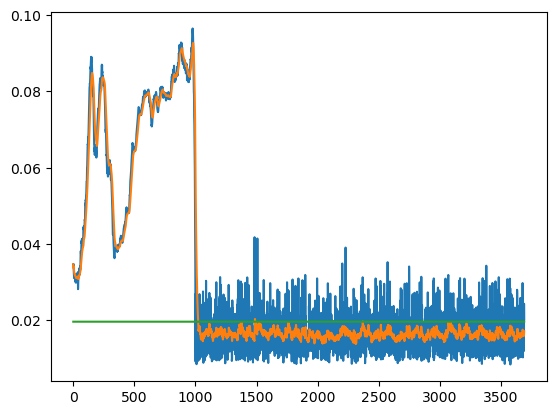

In [14]:
plt.plot(recon_error)
plt.plot(smoothed_error)
plt.plot([threshold for i in range(len(recon_error))])

### Save

In [15]:
test_df = pd.DataFrame([y_test,recon_error,smoothed_error,[threshold for i in range(len(recon_error))]])
test_df.index=['label','recon_error','smoothed_error','threshold']
file_path = 'plot_dataset_' + Paths[0][17:-12] + '.csv'
test_df.to_csv(file_path,index=True)

In [16]:
# losss = pd.DataFrame(loss_lst)
# losss.to_csv('losss.csv')

In [17]:
# torch.save(model,"model.pt")